In [8]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [9]:
# Kaggle Kernel-dependent
input_path = "../input/linnaeus-5-256x256/Linnaeus 5 256X256/"

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'test': 
    datasets.ImageFolder(input_path + 'test', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  
}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [9]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.3179, acc: 0.9013
test loss: 0.1096, acc: 0.9675
Epoch 2/3
----------
train loss: 0.1282, acc: 0.9555
test loss: 0.1044, acc: 0.9665
Epoch 3/3
----------
train loss: 0.1099, acc: 0.9623
test loss: 0.0955, acc: 0.9685


In [10]:
!mkdir models
!mkdir models/pytorch

In [11]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [13]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

In [11]:
validation_img_paths = ["test/bird/120_256.jpg",
                        "test/dog/110_256.jpg",
                        "test/flower/130_256.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [48]:
validation_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])

In [49]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[-2.5600,  6.0374, -4.4687, -3.9088, -0.3456],
        [-0.4320, -4.2701,  6.6646, -3.5513,  1.4838],
        [ 2.9300, -5.4547, -8.6800,  8.2174,  0.0689]],
       grad_fn=<AddmmBackward>)

In [50]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[1.8421821e-04, 9.9805403e-01, 2.7315762e-05, 4.7811853e-05,
        1.6866312e-03],
       [8.2253577e-04, 1.7712229e-05, 9.9353629e-01, 3.6345562e-05,
        5.5870963e-03],
       [5.0283521e-03, 1.1481080e-06, 4.5631030e-08, 9.9468285e-01,
        2.8762480e-04]], dtype=float32)

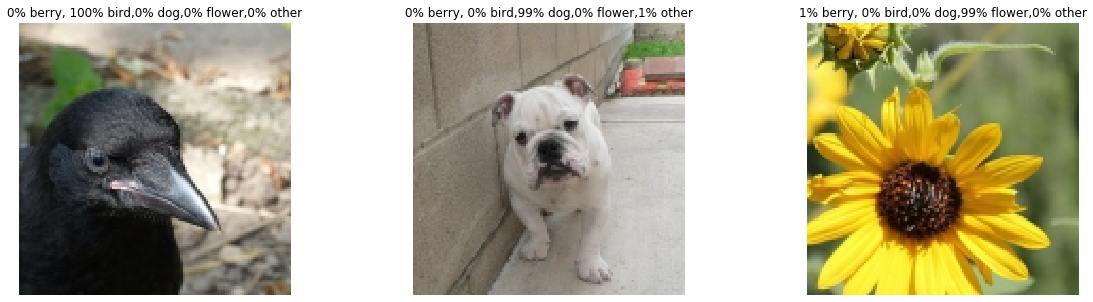

In [13]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% berry, {:.0f}% bird,{:.0f}% dog,{:.0f}% flower,{:.0f}% other".format(100*pred_probs[i,0],100*pred_probs[i,1],100*pred_probs[i,2],100*pred_probs[i,3],100*pred_probs[i,4]))
    ax.imshow(img)